# List of Requirements

In [145]:
# Libraries
# DATA MANAGEMENT
import pandas as pd
import numpy as np
from collections import Counter

# VISUALIAZATION
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# FILE SYSTEM
from os import listdir

# Title and Authors

# Introduction of Problem

Link of Dataset

# Opening the data 
### Stored in `df`

The data was previously converted from xlsx separated tables format into a csv. 

The conversion appears to be succesful but there are caveats:
<li>February 2019 xlsx was corrupted and not converted</li>
<li>There are days with entirely 0 entry & exit records</li>
<li>The records contain all days present only within said month. 31st and February leap days are excluded</li>

In [146]:
def read_CSV_in_years(YEARS = ('2019', '2020', '2021', '2022', '2023')):
    '''
    Parameters
    -----------
    YEARS        : Years to include/open.

    Parameters
    -----------
    Opens all the MRT train csv files within the provided years.
    Call cleanCSV() to open, clean, and return a dataframe.

    Return   
    ------------
    pd.Dataframe : All the cleaned CSVs compiled into a single dataframe.
    '''
    compiled_df = []
    FILES = listdir('MTR Parsed')

    # OPEN AND STORE ALL THE TARGET CSV FILES
    for fileName in FILES:
        if fileName[-4:] == '.csv' and fileName[:4] in YEARS:
            compiled_df.append(clean_CSV(fileName))
    
    return pd.concat(compiled_df)

In [147]:
def clean_CSV(fileName, min_traffic_threshold = 0):
    '''
    Parameters
    -----------
    fileName               : String name of the .csv file.
    min_traffic_threshold  : Stations records with daily traffic below the threshold will be dropped.

    Parameters
    -----------
    Open the csv file and drop all records of stations with little/no activity for the entire day.

    Return   
    ------------
    pd.Dataframe : The cleaned csv data.
    '''
    df = pd.read_csv('MTR Parsed/' + fileName)
    # REMOVE INDEX COL
    df = df.drop(df.columns[0], axis=1)

    # CHECK THE TRAFFIC ACTIVITY OF PER STATION EVERYDAY 
    '''
    activity_check = df[['Day', 'Station_No', 'Net_Traffic']]
    activity_check = activity_check.groupby(['Day', 'Station_No']).sum()
    
    # KEEP ONLY THE STATION RECORDS THAT HAD ACTIVITY FOR THAT DAY
    records_to_keep = activity_check[activity_check.values > min_traffic_threshold]
    df = df.set_index(['Day', 'Station_No']).join(records_to_keep, lsuffix='' , rsuffix='_ActivityCheck')
    df = df.dropna(axis=0)
    df = df.rename(columns={df.columns[-1]:'Station_Total_Day_Traffic'})
    '''
    
    df['Date'] = pd.to_datetime(df['Date'])
    # df = df.reset_index()
    
    return df

#### Contents

In [148]:
df = read_CSV_in_years()

df = df.reset_index().drop(columns='index')
df.tail()

Date           Time Station_Name  Station_No  Entry  Exit  \
531084 2023-12-31  02:00 - 02:59    Guadalupe           8      0   0.0   
531085 2023-12-31  02:00 - 02:59      Buendia           9      0   0.0   
531086 2023-12-31  02:00 - 02:59    Ayala Ave          10      0   0.0   
531087 2023-12-31  02:00 - 02:59   Magallanes          11      0   0.0   
531088 2023-12-31  02:00 - 02:59         Taft          12      0   0.0   

        Net_Traffic  Year  Month  Day  Hour  Weekday  Is_Holiday  
531084          0.0  2023     12   31     2        6        True  
531085          0.0  2023     12   31     2        6        True  
531086          0.0  2023     12   31     2        6        True  
531087          0.0  2023     12   31     2        6        True  
531088          0.0  2023     12   31     2        6        True

In [149]:
print(f'Entries: {df.shape}')

Entries: (531089, 13)


In [150]:
df.isnull().any()

Date            False
Time            False
Station_Name    False
Station_No      False
Entry           False
Exit            False
Net_Traffic     False
Year            False
Month           False
Day             False
Hour            False
Weekday         False
Is_Holiday      False
dtype: bool

# Feature modification

In [151]:
def convertToString(num : int):
    if(num < 10):
        return '0' + str(num)
    else:
        return str(num)

def joinNumsToString(df : pd.DataFrame, cols : list[str], separator = '_'):
    colName = cols[0] + separator + cols[1]
    df[colName] = df[cols[0]].apply(lambda x: convertToString(x)) +  separator + df[cols[1]].apply(lambda x: convertToString(x))

#### Timeseries string pairing
Additional features can be extracted to ease timeseries understanding. These could be making hours relative to months, days, etc.

In [152]:
joinNumsToString(df, ['Year', 'Month'])
joinNumsToString(df, ['Month', 'Hour'])
joinNumsToString(df, ['Weekday', 'Hour'])
joinNumsToString(df, ['Day', 'Hour'])

In [153]:
# Change Mon -> Sun range to 1 -> 7
df['Weekday'] += 1

# Incomplete records
### Dropping `Exit` and `Net_Traffic`
The data provided by MTR is acknowledged to be incomplete. Notes were left inside the xlsx files often marking that `Entry` was correct as opposed to `Exit`. 

<li> It records more entries than exits, rather than balancing/negating each other at 0 difference.</li>
<li> Extreme positive/negative outliers are also present. </li>


<br>Another issue are days with totally 0 records due to completely no entrance and exit for the day.

### To maintain consistency, `Entry` will be the metric used henceforth

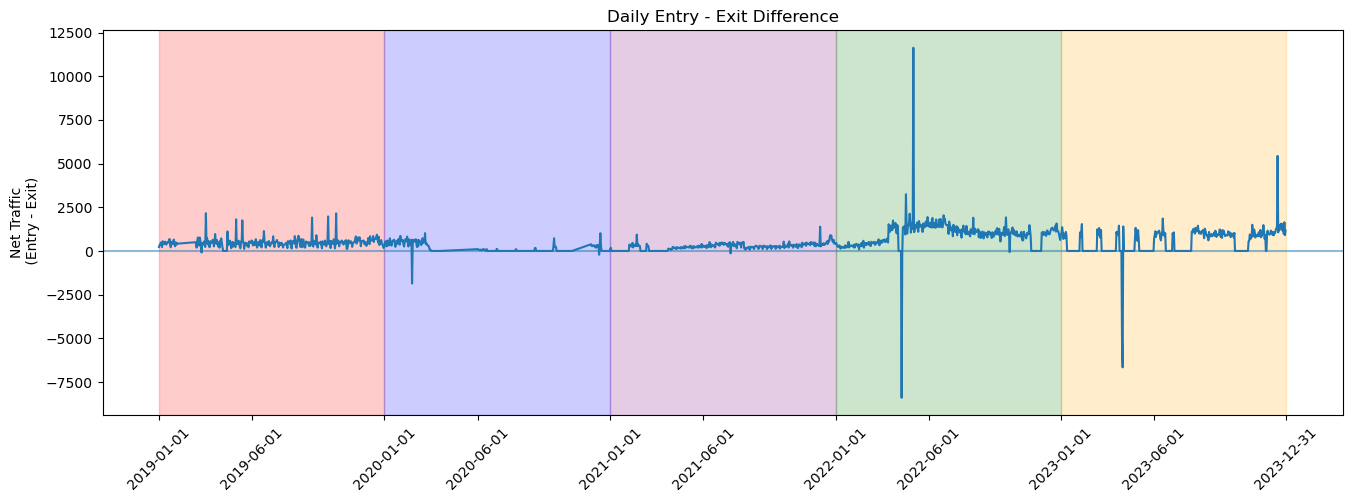

In [154]:
fig = plt.subplots(figsize=(16, 5))
plot_df = df[['Entry', 'Exit', 'Date']].groupby('Date').sum()
plt.plot(plot_df.index, plot_df['Entry']-plot_df['Exit'])

plt.title("Daily Entry - Exit Difference")
plt.ylabel("Net Traffic\n (Entry - Exit)")

ticks = ['2019-01-01',  '2019-06-01', 
         '2020-01-01',  '2020-06-01',
         '2021-01-01',  '2021-06-01',
         '2022-01-01',  '2022-06-01',
         '2023-01-01',  '2023-06-01', '2023-12-31']
plt.xticks(ticks, rotation=45)
plt.axvspan('2019-01-01', '2020-01-01', color='red', alpha=0.2)
plt.axvspan('2020-01-01', '2021-01-01', color='blue', alpha=0.2)
plt.axvspan('2021-01-01', '2022-01-01', color='purple', alpha=0.2)
plt.axvspan('2022-01-01', '2023-01-01', color='green', alpha=0.2)
plt.axvspan('2023-01-01', '2024-01-01', color='orange', alpha=0.2)

plt.axhline(0, alpha=0.5)

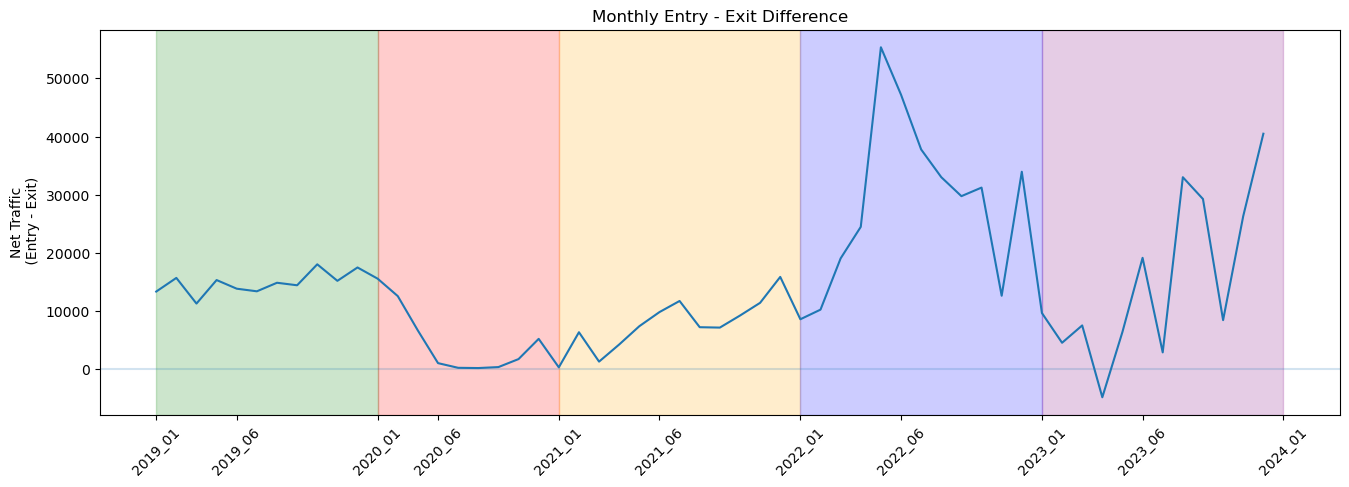

In [155]:
fig = plt.subplots(figsize=(16, 5))
plot_df = df[['Entry', 'Exit', 'Year_Month']].groupby('Year_Month').sum() 
plt.plot(plot_df.index, plot_df['Entry']-plot_df['Exit'])

plt.title("Monthly Entry - Exit Difference")
plt.ylabel("Net Traffic\n (Entry - Exit)")

ticks = []
for y in range(2019, 2024):
    for m in np.arange(1, 7, 5):
        ticks.append(str(y) + '_' + convertToString(m))
ticks.append('2024_01')

plt.xticks(ticks, rotation=45)

colors = ['green', 'red', 'orange', 'blue', 'purple']
max_range = len(ticks)//2
for i in range(0, max_range):
    plt.axvspan(ticks[2*i], ticks[i*2+2], color=colors[i % max_range], alpha=0.2)
plt.axhline(0, alpha=0.2)

In [156]:
df.drop(columns=['Exit', 'Net_Traffic'], inplace=True)

# Optimize formats
Safe to lower the int64 and float64 formats. They are within int16 range and entry rate are whole numbers.

This reduces memory usage from original 67.3 MB to ~35MB

In [157]:
convertCols = df.select_dtypes(['int', 'float']).columns
df[convertCols].max()

Station_No      12
Entry         7445
Year          2023
Month           12
Day             31
Hour            23
Weekday          7
dtype: int64

In [158]:
for col in convertCols:
    if df[col].max() <= 127:
        df[col] = df[col].astype('int8')
    elif df[col].max() <= 32767:
        df[col] = df[col].astype('int16')
    else:
        print(f"{col} data out of range")
        assert False
        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531089 entries, 0 to 531088
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          531089 non-null  datetime64[ns]
 1   Time          531089 non-null  object        
 2   Station_Name  531089 non-null  object        
 3   Station_No    531089 non-null  int8          
 4   Entry         531089 non-null  int16         
 5   Year          531089 non-null  int16         
 6   Month         531089 non-null  int8          
 7   Day           531089 non-null  int8          
 8   Hour          531089 non-null  int8          
 9   Weekday       531089 non-null  int8          
 10  Is_Holiday    531089 non-null  bool          
 11  Year_Month    531089 non-null  object        
 12  Month_Hour    531089 non-null  object        
 13  Weekday_Hour  531089 non-null  object        
 14  Day_Hour      531089 non-null  object        
dtypes: bool(1), datet

# Data Cleaning and Preprocessing

## Splicing to only Post-COVID Years [2022, 2023]
To keep data relevant, we will be utilizing the post COVID records as there are still over 220,000 hourly entries.

In [159]:
composition = df.groupby('Year').count()
composition['Percentage'] = composition.iloc[:,1] / composition.iloc[:,1].sum()
composition.rename(columns={"Time":"Number of Data Points"}, inplace=True)
composition[['Number of Data Points', 'Percentage']]

Number of Data Points  Percentage
Year                                   
2019                 105144    0.197978
2020                  84305    0.158740
2021                 113880    0.214427
2022                 113880    0.214427
2023                 113880    0.214427

In [160]:
df_splice = df[df['Year'] >= 2022].copy()
df_splice = df_splice.reset_index().drop(columns='index')

df_splice.shape

(227760, 15)

## Empty Daily Records
#### Certain months fail to properly record any entries in days proceeding the first week

Only the days of April 13-17 overlap in 0 entries for both years 2022 and 2023

In [161]:
template = 'simple_white'
color_palette = px.colors.qualitative.Vivid

In [162]:
plot_df = df_splice[['Date', 'Entry']].groupby('Date').sum().reset_index()
fig = px.line(plot_df, x='Date', y='Entry',
              template=template,
              title='<b>Daily Entry Volume from January 2022-2023</b><br>All stations')

fig.show()

In [163]:
df_daily_total = df_splice[['Date', 'Station_Name', 'Entry']].groupby(['Station_Name','Date']).sum().reset_index()
fig = px.line(df_daily_total, x='Date', y='Entry', 
              color='Station_Name',
              template=template,
              color_discrete_sequence=color_palette,
              title='<b>Daily Entry Volume from 2022-2023 </b><br>Per Station',
              )

fig.show()

In [164]:
df_splice['daily_total'] = df_splice.groupby(['Date', 'Station_Name'])['Entry'].transform('sum')
empty_records = df_splice[df_splice['daily_total'] == 0].drop(columns=['daily_total'])
print(empty_records.shape)
empty_records.tail()

(62400, 15)


Date           Time Station_Name  Station_No  Entry  Year  Month  \
218083 2023-11-30  02:00 - 02:59    Guadalupe           8      0  2023     11   
218084 2023-11-30  02:00 - 02:59      Buendia           9      0  2023     11   
218085 2023-11-30  02:00 - 02:59    Ayala Ave          10      0  2023     11   
218086 2023-11-30  02:00 - 02:59   Magallanes          11      0  2023     11   
218087 2023-11-30  02:00 - 02:59         Taft          12      0  2023     11   

        Day  Hour  Weekday  Is_Holiday Year_Month Month_Hour Weekday_Hour  \
218083   30     2        4        True    2023_11      11_02        03_02   
218084   30     2        4        True    2023_11      11_02        03_02   
218085   30     2        4        True    2023_11      11_02        03_02   
218086   30     2        4        True    2023_11      11_02        03_02   
218087   30     2        4        True    2023_11      11_02        03_02   

       Day_Hour  
218083    30_02  
218084    30_02  
218085    30_02  
218086    30_02  
218087    30_02

## Outlier Detection

In [165]:
fig = go.Figure()

# Define a list of 13 different colors
# color_palette = px.colors.qualitative.Light24

# Get unique station names
stations = list(df_splice['Station_Name'].unique())

# Add a violin trace for each station with a different color
for i, station in enumerate(stations):
    color = color_palette[i % len(color_palette)]  # Cycle through colors if there are more stations than colors
    fig.add_trace(go.Violin(x=df_splice['Station_Name'][df_splice['Station_Name'] == station],
                            y=df_splice['Entry'][df_splice['Station_Name'] == station],
                            line_color="black",
                            fillcolor=color,
                            name=station,
                            marker_outliercolor="white",
                            marker_line_outlierwidth=0.3,
                            box_visible=True,
                            meanline_visible=True))

# Update layout
fig.update_layout(
    title="Entry Volume Distribution per Station",
    xaxis_title="Station Name",
    yaxis_title="Entry Volume",
    template=template
)

fig.show()

It can be observed from the violin plots above that the hourly entry ridership data has a considerable amount of outliers. This is heavily evident in stations like North Avenue, Quezon Avenue, GMA Kamuning, Santolan, Ortigas, Buendia, Ayala, and Magallanes. Due to this, median will be used for imputing the null hourly entry ridership values.

## Imputation
#### Get the average entry and exit according to factors such as the...
<li>Year</li>
<li>Month</li>
<li>Weekday</li>
<li>Hour</li>
<li>Station</li>

#### `IMPUTATION_FACTORS` will control the resulting imputation. 
More specific factors will reduce its effect since some records (e.g. weekday specific to a month & year) will only be able to reference 0 values.

In [ ]:
# IMPUTATION_FACTORS = ['Year', 'Month', 'Hour', 'Station_Name']

# # AGGREGATE THE DATES W/ MEAN/MEDIAN
# AGG_df = df_splice[IMPUTATION_FACTORS + ['Entry']].copy()
# AGG_df.drop(empty_records.index, axis=0, inplace=True)
# AGG_df = AGG_df.groupby(IMPUTATION_FACTORS).mean().apply(np.round).reset_index()

# # MERGE THE AGGREGATED VALUES TO THE EMPTY DAYS.
# merged_df = pd.merge(empty_records, AGG_df, on=IMPUTATION_FACTORS, suffixes=('_Zero', '_Imputed'))

# # FIX THE SORTING BEFORE SETTING THE INDEX
# merged_df['Sort_Hour'] = (merged_df['Hour'] - 3) % 24
# merged_df.sort_values(['Date', 'Sort_Hour', 'Station_No'], inplace=True)
# merged_df.index = empty_records.index

# # COMBINE TO IMPUTED EMPTY DF TO THE ORIGINAL
# output = df_splice.copy()
# output.loc[merged_df.index, 'Entry'] = merged_df['Entry_Imputed']
# # return output

In [ ]:
IMPUTATION_FACTORS = [
    ['Year', 'Month', 'Hour', 'Station_Name'],
    ['Year', 'Hour', 'Station_Name'],
    ['Year', 'Hour'],
]


plot_df = None
for factor in IMPUTATION_FACTORS:
    for method in ('mean', 'median'):
        colName = method.upper() + ': ' + ', '.join(str(x) for x in factor)

        if plot_df is None:
            plot_df = impute_Empty_Records(df_splice, empty_records, method, factor)[['Date', 'Entry']] 
            plot_df.rename(columns={'Entry':colName}, inplace=True)
        
        else:
            plot_df[colName] = impute_Empty_Records(df_splice, empty_records, method, factor)['Entry']


fig = px.line(plot_df.groupby('Date').sum(), height=500, 
              title='<b>Daily Entries with Imputation from 2022-2023</b><br>Imputed the Days with 0 Entries')

fig.show()

## Select the best imputation method and factors

In [ ]:
# COMMENT OUT THE ASSERT WHEN A BEST IMPUTATION FACTOR IS ALREADY SELECTED
IMPUTATION_FACTORS = ['Year', 'Month', 'Hour', 'Station_Name'] 
# assert False


# DEFAULT IS TO IMPUTE WITH HOURLY STATION AVERAGES RESPECTIVE TO ITS MONTH & YEAR
df_splice = impute_Empty_Records(df_splice, 
                                 empty_records, 
                                 'mean',     
                                 IMPUTATION_FACTORS)

df_splice

#### Evaluation
The imputations are shown to be functioning as intened with zero values eliminated. <br>
No alterations were performed to the original records with at least one daily entry.

In [ ]:
plot_df = pd.DataFrame()

plot_df['Month_Hour'] = df_splice.reset_index()['Month_Hour']
plot_df['Entry_Imputed'] = df_splice.reset_index()['Entry']
plot_df['Entry_Original'] = df.query('Year >= 2022').reset_index()['Entry']

fig = px.line(plot_df.groupby('Month_Hour').mean(),
              labels= {'value':'Entry'},
              title='<b>Average Hourly Entry per Month</b><br>The imputed values follow the cycle.')

fig.update_xaxes(dtick=12)
fig.show()

## Remaining anomalies
There are still anomlies present such as there being high traffic during 12am-3am when the stations should be closed.

However it seems to originate from the **original dataset** rather than the imputations performed.

#### Majority of the anomalies occured from March 2022

In [ ]:
anomalies = df.query('Year >= 2022 and Hour < 4 and Entry > 0')
pd.pivot_table(anomalies, index='Hour', columns=['Year', 'Month'], values='Entry', aggfunc='sum')

# Exploratory Analysis

In [ ]:
def plot_Entry(colName, title, xlabel, xticks):
    analysis = df_splice[[colName, 'Station_Name', 'Entry']].groupby(['Station_Name', colName]).mean()
    fig = plt.subplots(figsize=(16, 5))

    for station in analysis.index.get_level_values('Station_Name').unique():
        plt.plot(analysis.loc[station], label=station)
    
    plt.legend()
    plt.grid()
    
    plt.title(title)
    plt.ylabel('Number of Commuters Entering') 
    plt.xlabel(xlabel) 
    plt.xticks(xticks)
    
    plt.show()

    # return analysis

In [ ]:
def plot_Traffic(color, x='Hour', y='Entry', height=500):
    df_fig = df_splice[[x, color, y]].groupby([x, color]).mean().reset_index()

    fig = px.line(df_fig, x=x, y=y, color=color, 
                  title='Average ' + y + ' per ' + color,
                 height=height)
    
    fig.update_xaxes(dtick=2)
    return fig

### Trends and Cycles


In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=[
    'Average Hourly Entry',
    'Average Weekly Entry',
    'Average Daily Entry',
    'Average Monthly Entry',
]
                   )


figures = [
    plot_Traffic('Station_Name', 'Hour', 'Entry'), 
    plot_Traffic('Station_Name', 'Weekday', 'Entry'),
    plot_Traffic('Station_Name', 'Day', 'Entry'),
    plot_Traffic('Station_Name', 'Month', 'Entry')
]

i = 0
for f in figures:
    for trace in range(len(f["data"])):
        fig.append_trace(f["data"][trace], row=(i//2)+1, col=(i%2)+1)
    i += 1

fig.update_layout(height=700)
fig.update_xaxes(dtick=2)
fig.update_xaxes(dtick=1, col=2, row=1)
fig.show()

In [ ]:
corr_matrix = df_splice[['Station_No', 'Entry', 'Year', 'Month','Day', 'Hour', 'Weekday', 'Is_Holiday']].corr()
fig = plt.subplots()

plt.imshow(corr_matrix)

# Add colorbar 
cbar = plt.colorbar(ticks=[0, 0.5, 1]) 
cbar.ax.set_yticklabels(['Low', 'Medium', 'High']) 
  
plt.xticks(range(len(corr_matrix.columns)),
           corr_matrix.columns, rotation=90) 
plt.yticks(range(len(corr_matrix.columns)), 
           corr_matrix.columns)
plt.title('Feature Correlation')


# Feature Extraction

# Model Training

# Feature Selection & Hyperparameter Tuning